In [ ]:
from IPython.display import *

# Setup Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import *

from tabulate import tabulate

# Setup numpy, pandas
import pandas as pd
import numpy as np

# Setup matplotlib
import matplotlib
import matplotlib.pyplot as plt
DEFAULT_W, DEFAULT_H = (16, 9)
matplotlib.rcParams["figure.figsize"] = [DEFAULT_W, DEFAULT_H]
matplotlib.rcParams["font.size"] = 15
matplotlib.rcParams["figure.dpi"] = 100

# Load data
FILE_NAME_RED = "winequality-red.csv"
FILE_NAME_WHITE = "winequality_white.csv"
Y_COL_NAME = "quality"

# Merge for both datasets (red wines, white wines)
data_red = pd.read_csv(FILE_NAME_RED, sep=",")
data_red.insert(11, "type", "red")

data_white = pd.read_csv(FILE_NAME_WHITE, sep=";")
data_white.insert(11, "type", "white")

data = pd.concat([data_red, data_white]).sample(frac=1, random_state=42)

## I. Statistiques

### A. Distribution et informations statistiques de base

In [ ]:
# Mean and Standard Pearson deviation

desc = data.describe()
print(tabulate(desc, headers=desc.columns, showindex=True))
reds = data[data["type"]=="red"]
whites = data[data["type"]=="white"]

x_red, y_red = np.unique(reds["quality"], return_counts=True)
x_white, y_white = np.unique(whites["quality"], return_counts=True)
plt.figure(facecolor="white")

width = 0.4

ax = plt.axes()
ax.set_facecolor("white")
plt.bar(x_red - 0.2, y_red, width, color="red")
plt.bar(x_white + 0.2, y_white, width, color="#CCCCCC")
plt.legend(["Vins rouges", "Vins blancs"])
plt.title("Distribution de la qualité des vins en fonction du type (rouge ou blanc)")

# Boxplot for each variable grouped by the quality values, removing qualitative variable "type" and the dataframe index
columns = data.columns.drop(["quality", "type"])

for column in columns:
    plt.figure()
    data.boxplot(column=column, by=["type", "quality"], grid=False)
    plt.title("Boîte à moustache de la variable \"{}\" en fonction du type de vin et de la note obtenue".format(column))
    plt.show()


### B. Pearson Correlation

In [ ]:
# # TODO
# # - distribution
# # - (FAIT) matrice de correlation (pearson correlation)
# # std, mean, boite moustache etc...
# # distribution par note

# corr = data.corr(method="pearson")
# # display(corr.style.background_gradient(cmap="coolwarm"))
# # classement:
# # top = abs(corr.loc[Y_COL_NAME]).sort_values(ascending=False)
# top = corr.loc[Y_COL_NAME][corr.index != Y_COL_NAME]
# sorted = abs(top).sort_values(ascending=False)
# display(top) # en abs car -1 donne une bonne correlation aussi (correlation negative)
# fig, ax = plt.subplots()
# ax.bar(x=sorted.index, height=top[sorted.index], width=1, edgecolor="black")
# ax.set_title("Classement des correlations des variables par rapport à la variable \"quality\"", fontdict={"size":25})
# for i, v in enumerate(top[sorted.index].values):
#     ax.text(i - 0.25, (v + np.sign(v) * 0.015) - 0.01, f"{round(v, 2):.2f}", color="black")
# # plt.axhline(1, linestyle="--")
# # plt.axhline(-1, linestyle="--")
# plt.ylabel("Pearson correlation", fontweight="light", fontsize="x-large")
# plt.xticks(rotation=67.5, horizontalalignment="right", fontweight="light", fontsize="large")
# plt.yticks(fontweight="light", fontsize="small")
# plt.show()

import seaborn as sns
correlations = data.corr()

sns.heatmap(correlations, annot=True, linewidths=.2, cmap="coolwarm")

### C. Colinéarité des variables

## II. Préparation des données

### A. Normalisation des données et encodage des variables qualitatives

In [10]:
from sklearn.model_selection import train_test_split
import category_encoders as ce

# La colonne type va être encodée pour qu"elle puisse être comprise dans l"analyse
encoder = ce.OneHotEncoder(cols="type", handle_unknown="return_nan", return_df=True, use_cat_names=True)

data_tf = encoder.fit_transform(data)

# X = ((X - X.mean()) / X.std()).values # Standardization colonne par colonne # (x - µ) / σ
# ou
# Normalisation min-max
def min_max_scaling(X):
    return (X - X.min()) / (X.max() - X.min())

# Réduction et centrage des valeurs autour de la moyenne
def norm_scaling(X):
    return ((X - X.mean()) / X.std())

X = data_tf.iloc[:, :-1]

X = min_max_scaling(X)

Y = data_tf.loc[:, Y_COL_NAME].values
Y = Y.reshape(-1, 1) # Y est scale entre 0 et 1 au moment de faire la regression (on garde les notes en entier pour le model de classif)



### B. Etude et limitation de la colinéarité des variables

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

def fix_multicollinearity(X, threshold=10):
    # Calcul de la VIF initiale
    vif = calc_vif(X)
    
    # Tri des VIF dans l'ordre décroissant
    sorted_vif = vif.sort_values(axis=0, by="VIF", ascending=False, ignore_index=True)
    
    # Extraction de la VIF la plus importante
    vif_top = sorted_vif.loc[0, "VIF"]
    
    # On mémorise le dataframe modifié X_mod, et on l'initialise à X
    X_mod = X
    
    # Tant que la VIF la plus grande est au-dessus du seuil
    while vif_top > threshold:
        # Suppression de la variable ayant la VIF la plus haute
        columns = sorted_vif.loc[1:, "variables"]
        
        # Extraction des colonnes n-1 colonnes restantes du dataframe, et on écrase le dataframe stocké dans X_mod
        X_mod = X_mod[columns]
        
        # Calcul de la VIF pour chaque variable
        vif = calc_vif(X_mod)
    
        # Tri des VIF dans l'ordre décroissant
        sorted_vif = vif.sort_values(axis=0, by="VIF", ascending=False, ignore_index=True)
        
        # Extraction de la VIF la plus importante
        vif_top = sorted_vif.loc[0, "VIF"]
    
    # La fonction retourne le dataframe sans les variables redondantes
    return X_mod
        
    

X = fix_multicollinearity(X, 8)

In [11]:
NB_CLASS = len(np.unique(Y))
NB_INPUT = X.shape[1] # nombre de variable en input des modeles
NB_DATA = X.shape[0]
# X, Y, X.shape, Y.shape

# Split train/test
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X, X_test, Y, Y_test = X.values, X_test.values, Y - 3, Y_test - 3
# Y_train = Y_train.reshape(-1)
# Y_test = Y_test.reshape(-1

# III. Modèles & Entrainments

### A. Définition des paramètres généraux

In [21]:
NB_CLASS = len(np.unique(Y))
NB_INPUT = X.shape[1] # nombre de variable en input des modeles
NB_DATA = X.shape[0]

### B. Définition du réseau de neurones

In [13]:
from tensorflow.keras.activations import *

def classification_model(DROP_RATE = 0.1, RELU_ALPHA = 0.2, N_NEURONES = 32, N_LAYERS = 1):
	
	input = Input(shape=(NB_INPUT,), name="input")
	x = LayerNormalization()(input)

	for _ in range(N_LAYERS):
		x = LeakyReLU(RELU_ALPHA)(BatchNormalization()(Dense(N_NEURONES)(x)))
		x = Dropout(DROP_RATE)(x)
	
	output = Dense(NB_CLASS, activation=Softmax(), name="prediction")(x)
	
	return Model(input, output, name="classification_model")

# NOTE: Entrainement fait dans la CV plus bas
# epochs = 50
# lr = 1e-2
# batch_size = 32

# classModel = classification_model(DROP_RATE = 0.2, RELU_ALPHA = 0.2, N_NEURONES = 32, N_LAYERS = 3)
# classModel.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=Adam(lr))
# classModel.summary()
#
# hclass = classModel.fit(X, Y, validation_data=[X_test, Y_test], batch_size=batch_size, epochs=epochs)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 / 10**(epoch/50) ) # 
# hclass = classModel.fit(X_train, Y_train, validation_data=[X_test, Y_test], batch_size=32, epochs=200, callbacks=[lr_schedule])

### C. Définition des modèles de régression/classification et de la fonction d"entraîntement par KFold validation

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Ridge",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes"
]

classifiers = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(),
    RidgeClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB()
]

def apply_model(model, X_train, X_test, Y_train, Y_test):
	model.fit(X_train, Y_train)
	print("Précision du modèle : %0.2f" % model.score(X_test, Y_test))
	return model
    
def apply_model_cv(model, X_train, Y_train, cv, scoring=None):
    return cross_validate(model, X_train, Y_train, cv=cv, scoring=scoring)


# On ne peut pas aller au dessus de 4 splits, car il existe une classe dans y dont la population est de 4 individus
cv = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

### D. Application des modèles et résultats

#### 1. Evaluation des modèles de classification

In [ ]:
from time import time

# Définition des méthodes de scoring
scoring = ["f1_weighted", "accuracy"]

# Création des clés pour la cross validation
keys = ["test_" + score for score in scoring]

# Définition des colonnes du dataframe de résultats
columns = ["classifier"] + [x + y for x in ["mean ", "std "] for y in keys] + ["running time"]

# Création du dataframe de résultat
results = pd.DataFrame(columns=columns)

for i in range(len(classifiers)):
    clf = classifiers[i]
    print("*** Modèle :", names[i], "***")
    
    start = time()
    scores = apply_model_cv(clf, X, Y.reshape(-1), cv, scoring)
    end = time()
    
    time_diff = np.around(end - start, 2)
    
    results.loc[results.shape[0]] = [names[i], np.mean(scores[keys[0]] * 100), np.mean(scores[keys[1]] * 100), np.std(scores[keys[0]] * 100), np.std(scores[keys[1]] * 100), time_diff]
    
    print(f"Temps d'exécution : {time_diff}s\n")
    

In [ ]:
print(tabulate(results.sort_values("mean test_f1_weighted", ascending=False), headers=columns, showindex=False))

#### 2. Evaluation du réseau de neurones

In [ ]:
from tensorflow.keras.metrics import *


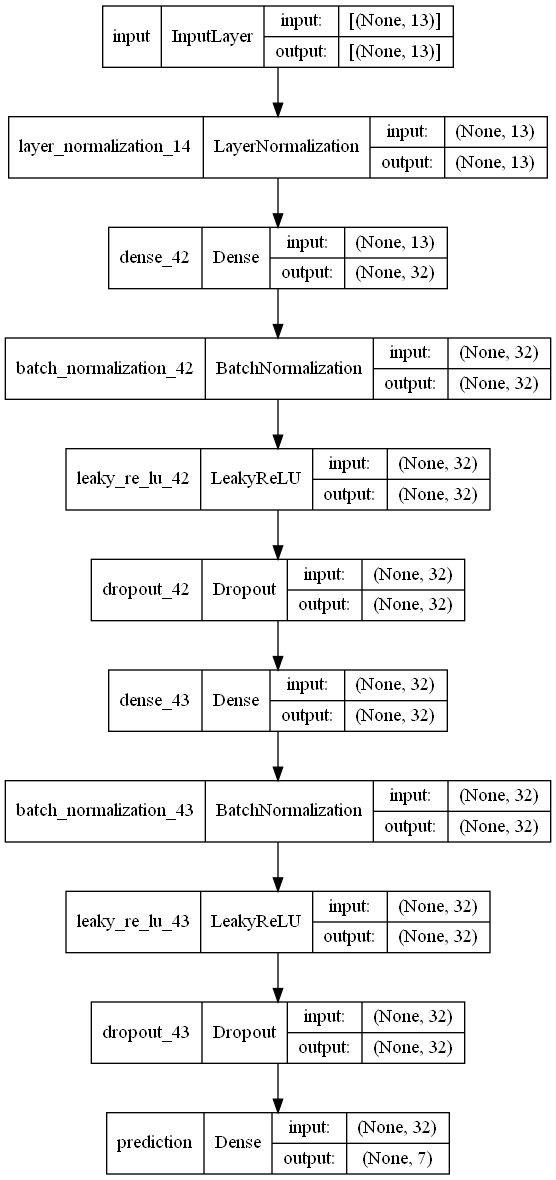

In [44]:
m = classification_model(DROP_RATE = 0.0, RELU_ALPHA = 0.2, N_NEURONES = 32, N_LAYERS = 2)
tf.keras.utils.plot_model(m, "model.png", show_shapes=True)

In [122]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(Y), Y.reshape(-1))
print(class_weights)
class_weights = {k: v for k, v in zip(np.arange(7), class_weights)}
class_weights

[ 28.55494505   4.26683087   0.43064302   0.32952888   0.86530137
   4.69891501 185.60714286]


C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[3 3 2 ... 4 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 28.554945054945055,
 1: 4.266830870279146,
 2: 0.43064302287040107,
 3: 0.3295288821254201,
 4: 0.8653013653013653,
 5: 4.698915009041591,
 6: 185.60714285714286}

In [125]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.metrics import *
epochs = 100
lr = 1e-3
batch_size = 500

# On ne peut pas aller au dessus de 4 splits, car il existe une classe dans y dont la population est de 4 individus
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

hclass = []
for fi, (train_i, val_i) in enumerate(cv.split(X, Y)):
	x_train, y_train = X[train_i], Y[train_i]
	x_val, y_val = X[val_i], Y[val_i]

	classModel = classification_model(DROP_RATE = 0.1, RELU_ALPHA = 0.2, N_NEURONES = 64, N_LAYERS = 3)
	classModel.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=Adam(lr))
	hclass.append(classModel.fit(x_train, y_train, validation_data=[x_val, y_val], batch_size=batch_size, epochs=epochs, class_weight=class_weights))


C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Epoch 1/100
9/9 [==============================] - 3s 51ms/step - loss: 2.2500 - accuracy: 0.0710 - val_loss: 2.0300 - val_accuracy: 0.0760
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 1.9207 - accuracy: 0.1145 - val_loss: 1.9828 - val_accuracy: 0.1192
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 1.7842 - accuracy: 0.1641 - val_loss: 1.9494 - val_accuracy: 0.1558
Epoch 4/100
9/9 [==============================] - 0s 14ms/step - loss: 1.6008 - accuracy: 0.1840 - val_loss: 1.9288 - val_accuracy: 0.1413
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 1.5823 - accuracy: 0.2011 - val_loss: 1.9066 - val_accuracy: 0.1519
Epoch 6/100
9/9 [==============================] - 0s 12ms/step - loss: 1.5324 - accuracy: 0.2038 - val_loss: 1.8759 - val_accuracy: 0.1952
Epoch 7/100
9/9 [==============================] - 0s 12ms/step - loss: 1.4915 - accuracy: 0.2271 - val_loss: 1.8362 - val_accuracy: 0.2452
Epoch 8/100
9/9 [===

Exception ignored in: <function EagerResourceDeleter.__del__ at 0x00000200DF9704C0>
Traceback (most recent call last):
  File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 281, in __del__
    try:
KeyboardInterrupt: 


9/9 [==============================] - 59s 52ms/step - loss: 2.2398 - accuracy: 0.0924 - val_loss: 1.9948 - val_accuracy: 0.0500
Epoch 2/100
9/9 [==============================] - 0s 28ms/step - loss: 1.8823 - accuracy: 0.1133 - val_loss: 1.9600 - val_accuracy: 0.1088
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 1.7216 - accuracy: 0.1397 - val_loss: 1.9200 - val_accuracy: 0.1463
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 1.6737 - accuracy: 0.1667 - val_loss: 1.8823 - val_accuracy: 0.2079
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 1.6162 - accuracy: 0.1950 - val_loss: 1.8461 - val_accuracy: 0.2599
Epoch 6/100
9/9 [==============================] - 0s 12ms/step - loss: 1.5908 - accuracy: 0.2063 - val_loss: 1.8099 - val_accuracy: 0.3215
Epoch 7/100
9/9 [==============================] - 0s 12ms/step - loss: 1.5259 - accuracy: 0.2316 - val_loss: 1.7738 - val_accuracy: 0.3657
Epoch 8/100
9/9 [==============

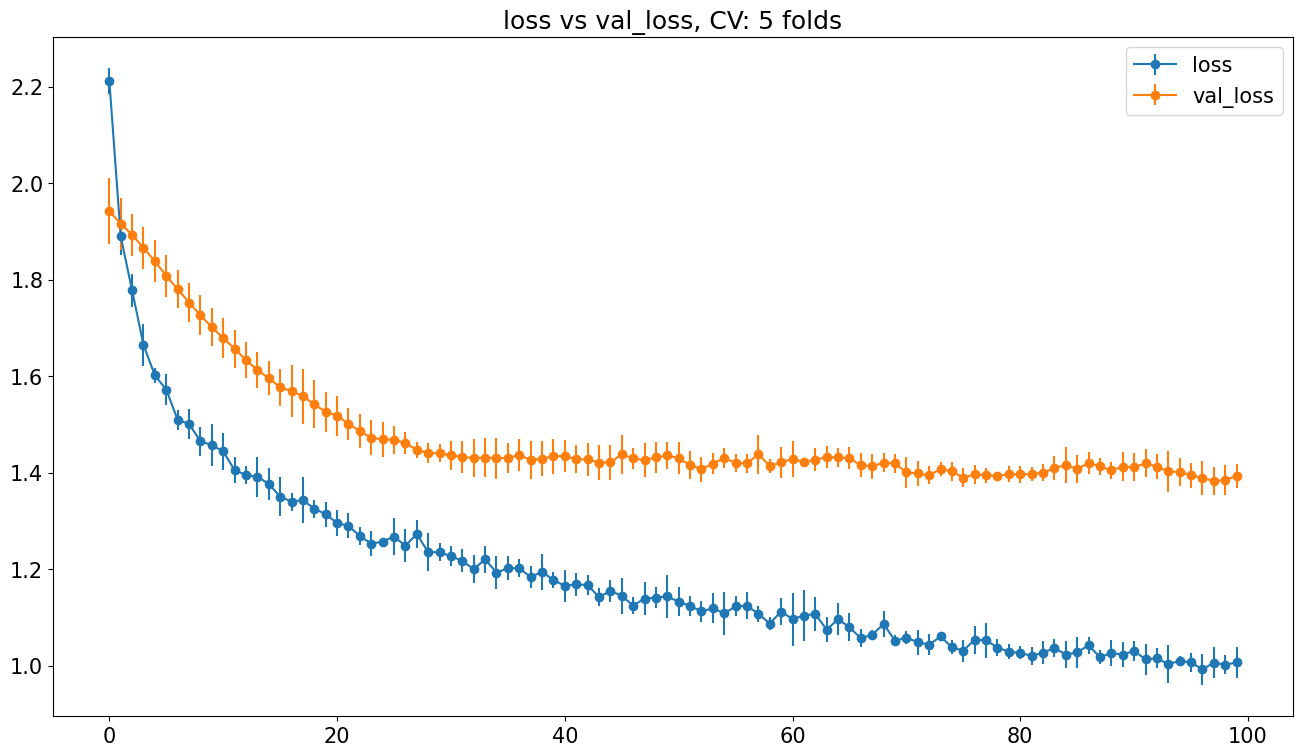

In [126]:
def get_metrics(hist, name="loss"):
	return np.array([h.history[name] for h in hist])
loss = get_metrics(hclass, "loss")
val_loss = get_metrics(hclass, "val_loss")
# plt.plot(np.mean(loss, axis=0))
# plt.plot(np.mean(val_loss, axis=0))
plt.errorbar(x=range(loss.shape[1]), y=np.mean(loss, axis=0), yerr=np.std(loss, axis=0), label="loss", fmt="o-")
plt.errorbar(x=range(val_loss.shape[1]), y=np.mean(val_loss, axis=0), yerr=np.std(val_loss, axis=0), label="val_loss", fmt="o-")
plt.title("loss vs val_loss, CV: 5 folds")
plt.legend()
plt.show()

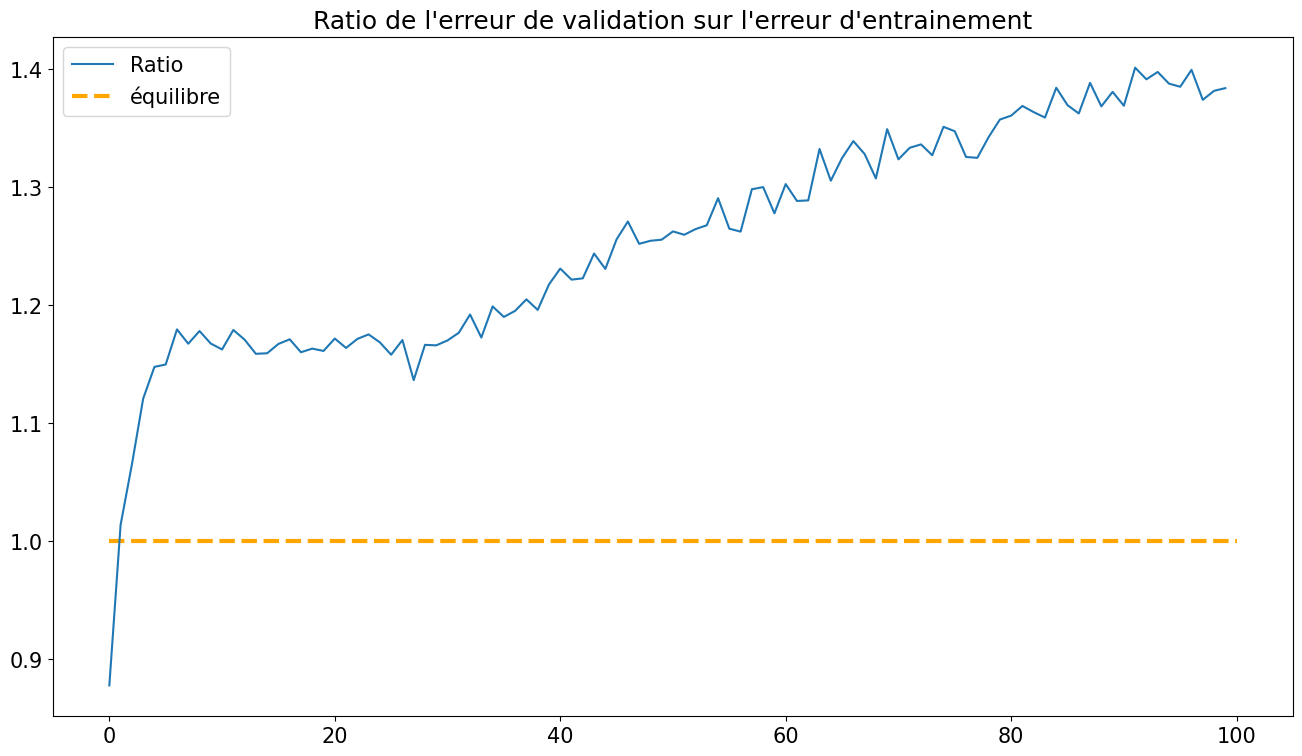

In [127]:
def get_metrics(hist, name="loss"):
	return np.array([h.history[name] for h in hist])
loss = get_metrics(hclass, "loss")
val_loss = get_metrics(hclass, "val_loss")

plt.title("Ratio de l'erreur de validation sur l'erreur d'entrainement")
plt.hlines(y=1, xmin=0, xmax=epochs, linestyles='--', label="équilibre", color="orange", lw=3)
plt.plot(np.mean(val_loss, axis=0) / np.mean(loss, axis=0), label="Ratio")
plt.legend()

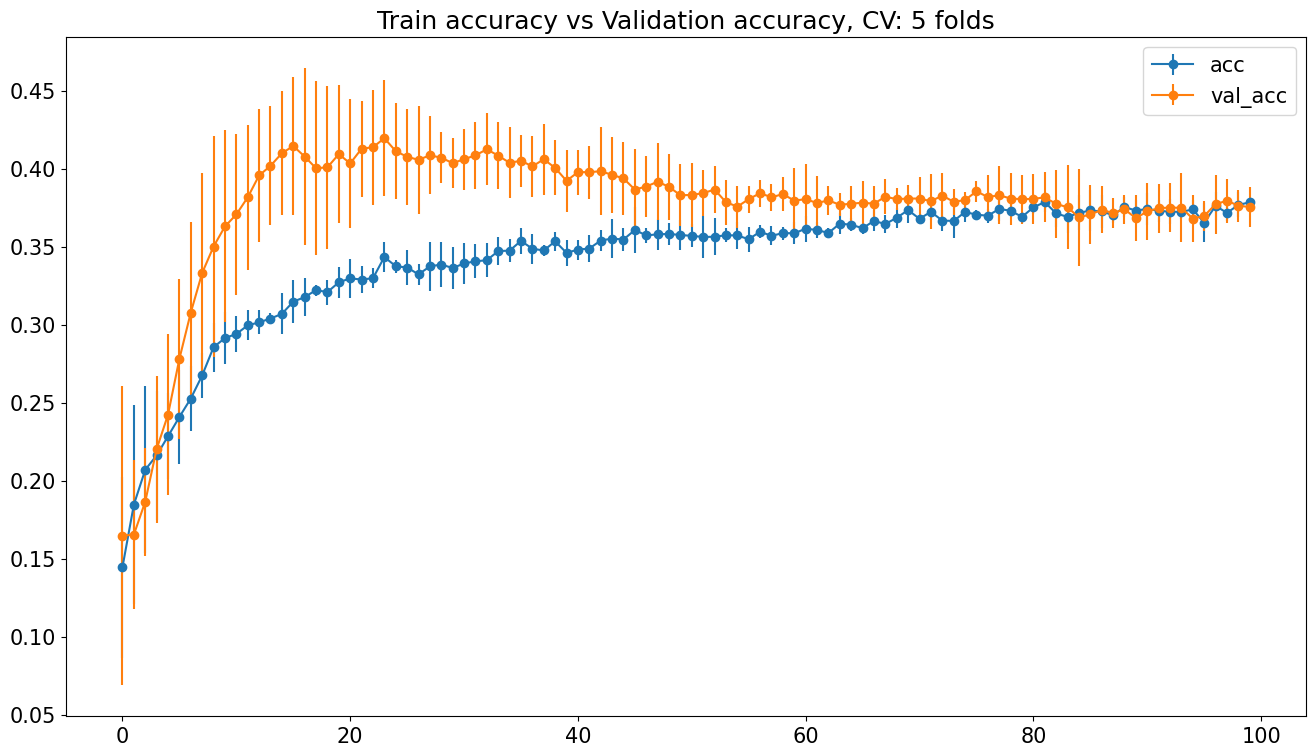

In [128]:
acc = get_metrics(hclass, "accuracy")
val_acc = get_metrics(hclass, "val_accuracy")
# plt.plot(np.mean(acc, axis=0))
# plt.plot(np.mean(val_acc, axis=0))
plt.errorbar(x=range(acc.shape[1]), y=np.mean(acc, axis=0), yerr=np.std(acc, axis=0), label="acc", fmt="o-")
plt.errorbar(x=range(val_acc.shape[1]), y=np.mean(val_acc, axis=0), yerr=np.std(val_acc, axis=0), label="val_acc", fmt="o-")
plt.title("Train accuracy vs Validation accuracy, CV: 5 folds")
plt.legend()
plt.show()

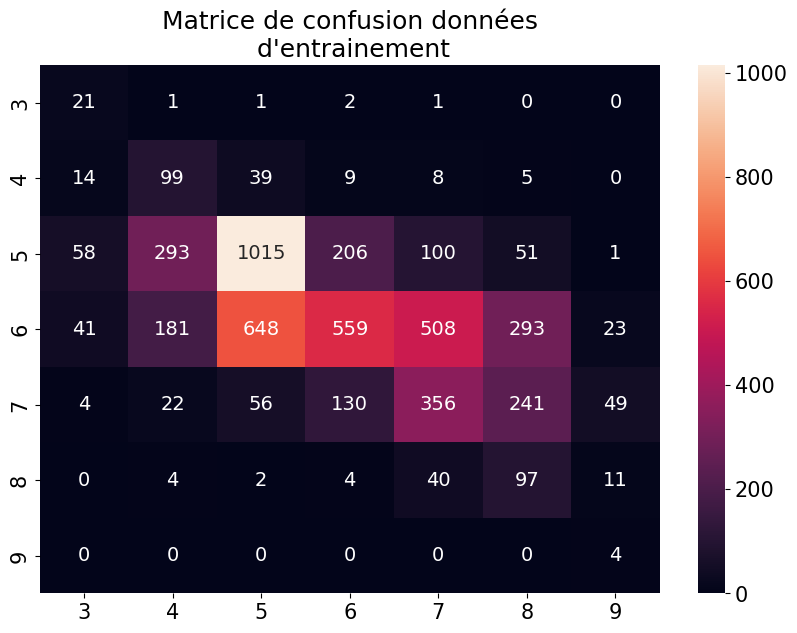

<AxesSubplot:title={'center':"Matrice de confusion données\n d'entrainement en pourcentage par modalité"}>

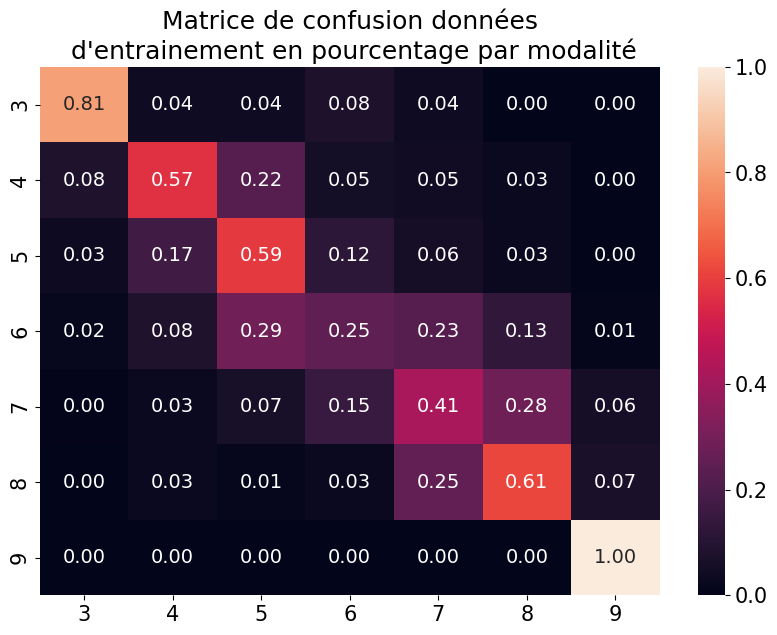

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = 3 + np.argmax(classModel.predict(X), axis=1)
Y_true = 3 + Y
cm = confusion_matrix(Y_true, Y_pred, labels=np.unique(Y_true))
plt.figure(figsize = (10,7))
plt.title("Matrice de confusion données\n d'entrainement")
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt="g", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))
plt.show()
plt.figure(figsize = (10,7))
plt.title("Matrice de confusion données\n d'entrainement en pourcentage par modalité")
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt=".2f", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))

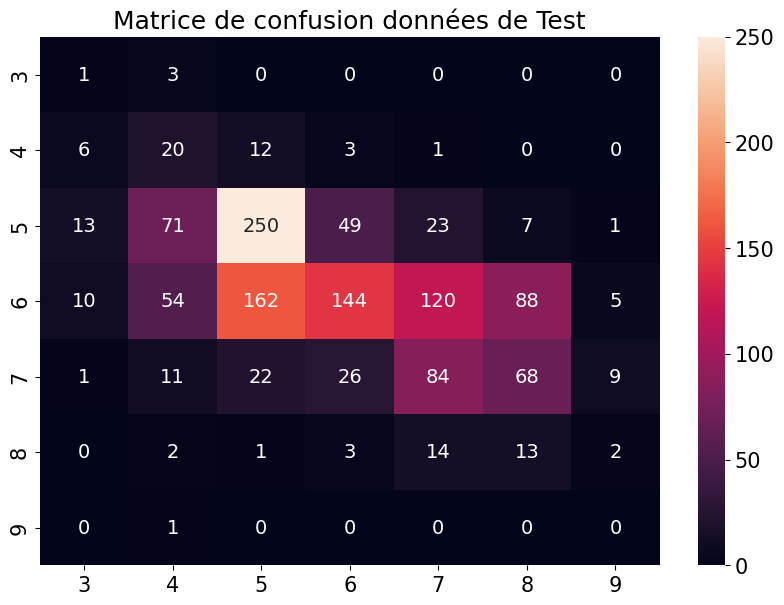

<AxesSubplot:title={'center':'Matrice de confusion données\n de Test en pourcentage par modalité'}>

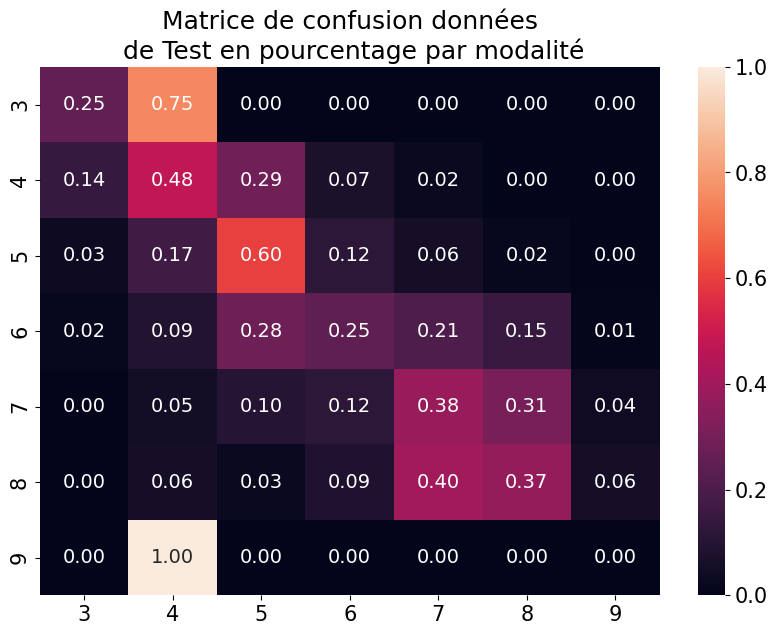

In [130]:
Y_pred = 3 + np.argmax(classModel.predict(X_test), axis=1)
Y_true = 3 + Y_test
cm = confusion_matrix(Y_true, Y_pred, labels=np.unique(Y_true))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt="g", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))
plt.title("Matrice de confusion données de Test")
plt.show()
plt.figure(figsize = (10,7))
plt.title("Matrice de confusion données\n de Test en pourcentage par modalité")
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt=".2f", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))

# IV Evaluations

In [ ]:
# TODO Cross Val pour test different meta parametre
# plot les resultats + leur std par epochs

# TODO tester l"accuracy de la classif en faisant apparaitre aussi le second choix du model
# possible aussi de regarder si les deux premier choix sont "proche" (cad si une prediction à 5 en choix 1 est suivit par un 4 ou 6 en choix 2 (faisable en faaisant mean(abs(choix1-choix2)))))

# V Conclusion

In [ ]:
# TODO Conclure
# TODO souligner les limites du dataset: que 3 votants, manque d"element en input comme le prix, les labels de qualité etc pour que le model soit pertinent dans le cadre d"une utilisation de classification de vin en situation de vente reel